#  import kit

In [39]:
import math, cmath
import numpy as np
import importlib
import pec_module as pec
import pec_module_FID_cnot_test as peccx
import Restore_Retrieve as RR

import qiskit as q
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler, QiskitRuntimeService

In [ ]:
importlib.reload(pec)
importlib.reload(peccx)
importlib.reload(RR)

<module 'Restore_Retrieve' from '/home/xiaonan/PEC/Restore_Retrieve.py'>

In [3]:
token = "PJubuPXreZKAxan0yV6OLEIkdKipFYGgvvkGQSZAtpMU"
instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/f071734952cb4c9993a642d0a87d18bb:392306ae-fe55-475c-a8c5-978d0ba1871e::'
device_name = "kingston"
device = "ibm_" + device_name
device, noise_model, service = pec.load_ibm_backend(token, instance, device)

In [40]:
estimator, t_backend = pec.make_noisy_estimator_from_device(
    real_backend=device,
    shots=1024,           # 想放大/縮小 shot 就改這裡
    seed_simulator=12345  # 可選；要可重現就給 seed
)


# Fixed parameters

In [6]:
np.set_printoptions(precision=15, suppress=False)

#520C-10
Gamma_e = 2.8025 #(1/s.T)
Gamma_C13 = 1.0704*10**-3 #(1/s.T)
ti = 0 
tf = 3
itv = 1
tlist = np.arange(ti, tf+itv, itv)
BZ = [0]   #BZ = 0 50 100 200
def split(array, lengths):
    result = []
    idx = 0
    for length in lengths:
        result.append(array[idx:idx+length])
        idx += length
    return result
Rvector = ([np.array([0.07281108260423003, 0.3783374832738622, 0.36039647178489426])])#10  #13C的位置向量
# grouping = [2, 2, 2, 2, 2]
grouping = [1]
R = split(Rvector, grouping)
#v,c,a用不同QC要改位置
#c、a用array後面的code才不用改
v = 2
# c = np.zeros(len(R))
# c = c.astype(int)
# for i in range (len(c)):
#     c[i] = i + 1
# a = np.zeros(len(c))
# a = a.astype(int)
# for i in range (len(c)):
#     a[i] = i + len(c) + 1
c = [1]
a = [0]

bits_len = max(v, max(max(c), max(a))) + 1
bits_len

3

# Calculate Readout PEC Observable

In [12]:
device_qubits = backendqubitNum
qubit_numbers = 4
initial_circuits_v = pec.build_initial_states(v)
measurements = pec.build_measurement_pauli(v, observable_number=backendqubitNum)
# job = pec.run_measurements(initial_circuits_v, measurements, backend, shots=1000)
# g_matrix = pec.collect_results(job, qubit_numbers)
# A_matrix = pec.get_preparation_matrix(qubit_numbers)
# B_matrix, noisy_coefficient = pec.build_corrected_observables(g_matrix, A_matrix, qubit_numbers)
# ideal_measurements = pec.build_ideal_measurement(noisy_coefficient, v, qubit_numbers, device_qubits)
# ideal_measurements

In [ ]:
B_matrix

array([[ 1.    ,  0.    ,  0.    ,  0.    ],
       [-0.0129,  1.0013,  0.0097,  0.0015],
       [ 0.0055, -0.0041,  0.9737, -0.0053],
       [-0.0019,  0.0097, -0.0017,  0.9871]])

# parameters

In [7]:
def normalize(h): 
    a = h / np.sqrt(np.sum(h**2))
    return a

def A_z(h):
    n = 0.0198763
    d = (np.sqrt(np.sum(h**2)))**3
    a_x = (n/d)*(-3)*normalize(h)[2]*normalize(h)[0]
    a_y = (n/d)*(-3)*normalize(h)[2]*normalize(h)[1]
    a_z = (n/d)*(1-3*normalize(h)[2]**2)

    return np.array([a_x, a_y, a_z])

R_z = np.zeros([len(BZ),len(tlist)]) 
theta = np.zeros([len(BZ),len(R),len(R[0]),len(tlist)])
phi = np.zeros([len(BZ),len(R),len(R[0]),len(tlist)])
Lambda = np.zeros([len(BZ),len(R),len(R[0]),len(tlist)])
gamma = np.zeros([len(BZ),len(R),len(R[0]),len(tlist)])

for r in range(len(R)):
    for bz in range(len(BZ)):
        omega_0 = (0,0,Gamma_C13*BZ[bz])
        for i in range(len(tlist)):         
            for p in range(len(R[r])):
                omega_1 = np.array([A_z(R[r][p])[0],A_z(R[r][p])[1],A_z(R[r][p])[2]+Gamma_C13*BZ[bz]])
                
                normalized_omega1 = normalize(omega_1)

                R_z[bz][i] = 2*np.pi*omega_0[2]*(itv*i+ti)

                theta[bz][r][p][i] = (2*math.asin(math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2) *np.sqrt(normalized_omega1[0]**2 + normalized_omega1[1]**2)))

                phi[bz][r][p][i] = ((-np.pi)/2
                +cmath.polar(complex(normalized_omega1[0],normalized_omega1[1]))[1]
                - cmath.polar(
                    complex(
                        math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                        -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])

                Lambda[bz][r][p][i] = ((np.pi)/2
                -cmath.polar(complex(normalized_omega1[0],normalized_omega1[1]))[1]
                - 2*np.pi*Gamma_C13*BZ[bz]*(itv*i+ti)
                - cmath.polar(
                    complex(
                        math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                        -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])

                gamma[bz][r][p][i] =((2*np.pi*Gamma_C13*BZ[bz]*(itv*i+ti))/2
                +cmath.polar(complex(
                        math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                        -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])


In [8]:
#根據v,c,a的位置設定qubit的位元
qreg = QuantumRegister(bits_len, 'q')
creg = ClassicalRegister(bits_len, 'c')

# wrapping circuit as {"bz0": [[carbon set], [carbon set], ... , [carbon set]], "bz1":[time list], ..., "bzn":[time list]}
qc_bzls = {}
for bz in range(len(BZ)): 
    qc_tmls = []    
    for i in range (len(tlist)):
        qc_cbls = []
        for r in range (len(R)): 
            #IBM空白的電路圖
            circuit = QuantumCircuit(qreg, creg)

            #State preparation & polarization
            circuit.h(v)
            for j in range (len(R[r])):
                circuit.h(c[j])
                circuit.cx(c[j], a[j])
                # circuit.u((np.pi)/2, 0, 0, c[j])

            #FID
            for j in range (len(R[r])):
                circuit.rz(R_z[bz][i], c[j])
                #C
                circuit.p(gamma[bz][r][j][i] + (phi[bz][r][j][i] + Lambda[bz][r][j][i])/2, v)
                circuit.p((Lambda[bz][r][j][i] - phi[bz][r][j][i])/2, c[j])
                #CX
                circuit.cx(v, c[j])
                #B
                circuit.u(-theta[bz][r][j][i]/2, 0, (phi[bz][r][j][i] + Lambda[bz][r][j][i])/2, c[j])
                #CX
                circuit.cx(v, c[j])
                #A
                circuit.u(theta[bz][r][j][i]/2, phi[bz][r][j][i], 0, c[j])

            qc_cbls.append(circuit)
        qc_tmls.append(qc_cbls)
    qc_bzls.update({f'{BZ[bz]}':qc_tmls})

In [10]:
qc_bzls['0']

[[<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x73f3ddd785b0>],

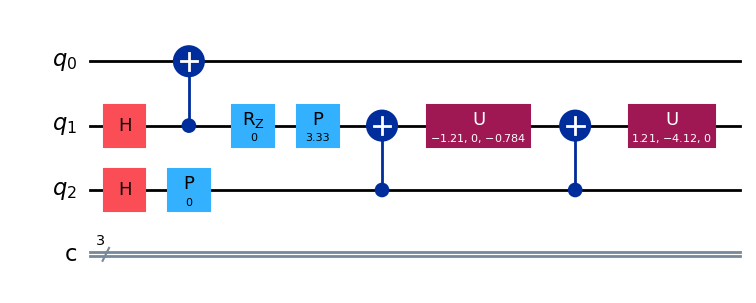

In [11]:
display(qc_bzls['0'][2][0].draw(output='mpl'))

In [13]:
from qiskit.primitives import BackendEstimator

In [28]:
sim = AerSimulator.from_backend(device)
est = BackendEstimator(backend=sim)
simI = AerSimulator()
estI = BackendEstimator(backend=simI)
est.options.default_shots = 20000  
estI.options.default_shots = 20000  

/tmp/ipykernel_1094228/3667264712.py:2: DeprecationWarning: The class ``qiskit.primitives.backend_estimator.BackendEstimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendEstimator` class is `BackendEstimatorV2`.
  est = BackendEstimator(backend=sim)
/tmp/ipykernel_1094228/3667264712.py:4: DeprecationWarning: The class ``qiskit.primitives.backend_estimator.BackendEstimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendEstimator` class is `BackendEstimatorV2`.
  estI = BackendEstimator(backend=simI)


In [ ]:
result = []
result1 = []
meas = Pauli('X' + 'II') 
for i in range (4):
    CirTran = q.compiler.transpile(qc_bzls['0'][i][0], backend=simI, optimization_level=0)
    res = est.run(CirTran, meas).result()
    result.append(getattr(res, "values", None))
    resI = estI.run(CirTran, meas).result()
    result1.append(getattr(resI, "values", None))

[array([0.99609375]), array([0.73828125]), array([0.267578125]), array([-0.46484375])]
[array([1.]), array([0.80078125]), array([0.259765625]), array([-0.396484375])]


In [30]:
simS = AerSimulator(method='statevector')
estS = BackendEstimator(backend=simS)
resultS = []
for i in range (4):
    CirTran = q.compiler.transpile(qc_bzls['0'][i][0], backend=simI, optimization_level=0)
    resS = estS.run(CirTran, meas).result()
    resultS.append(getattr(resS, "values", None))

/tmp/ipykernel_1094228/4119693434.py:2: DeprecationWarning: The class ``qiskit.primitives.backend_estimator.BackendEstimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendEstimator` class is `BackendEstimatorV2`.
  estS = BackendEstimator(backend=simS)


In [31]:
print(result)
print(result1)
print(resultS)

[array([0.99609375]), array([0.73828125]), array([0.267578125]), array([-0.46484375])]
[array([1.]), array([0.80078125]), array([0.259765625]), array([-0.396484375])]
[array([1.]), array([0.76171875]), array([0.232421875]), array([-0.375])]


In [ ]:
# 1) BackendEstimator 真的掛在 AerSimulator 上？
print(type(est.backend))     # 應該是 qiskit_aer.AerSimulator
print(type(estI.backend))    # 也是 AerSimulator，但理想

# 2) 這個 AerSimulator 有沒有 noise_model？
# 近年的 AER 版本可用 options/noise_model；有些版本要用 set_options / configuration
has_noise = getattr(est.backend.options, "noise_model", None) is not None
print("noisy-sim has noise_model?:", has_noise)

# 3) 也可以看 basis_gates / coupling_map 是否繫結到裝置
print("noisy basis_gates:", est.backend.configuration().basis_gates[:10])
print("noisy coupling_map len:", len(est.backend.configuration().coupling_map or []))

<class 'qiskit_aer.backends.aer_simulator.AerSimulator'>
<class 'qiskit_aer.backends.aer_simulator.AerSimulator'>
noisy-sim has noise_model?: True
noisy basis_gates: ['cz', 'id', 'rz', 'sx', 'x', 'break_loop', 'continue_loop', 'delay', 'for_loop', 'if_else']
noisy coupling_map len: 352
